<a href="https://colab.research.google.com/github/modhudeb/Intent-classification-BiLSTM-CNN/blob/main/CB_intentReco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [3]:
# downlaods
# !pip install contractions nlpaug
!pip install contractions

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import os
import re
import pickle
import contractions

In [7]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

In [8]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras import regularizers
from keras.layers import Layer
import keras.backend as K

# load data

In [9]:
df = pd.read_parquet('train.parquet')
tdf = pd.read_parquet('val.parquet')


# Data Analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15250 entries, 0 to 15249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15250 non-null  object
 1   intent  15250 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 238.4+ KB


In [11]:
df.sample(5)

,text,intent
2418,can you get me a table for 2 at diablo,23
7757,when's my heater bill due,56
6663,i'd like you to roll a 6 sided dice,92
7938,the plastic numbers on my card are falling off,87
2504,what's my savings balance at chase,35


We will read the json file for the intent labels

In [12]:
jso = pd.read_json('dataset_infos.json')
jso.drop(columns=['small', 'imbalanced'], inplace = True)
jso

,plus
description,This dataset is for evaluating the perform...
citation,@inproceedings{larson-etal-2019-evaluation...
homepage,https://github.com/clinc/oos-eval/
license,
features,"{'text': {'dtype': 'string', 'id': None, '_typ..."
post_processed,None
supervised_keys,None
builder_name,clinc_oos
config_name,plus
version,"{'version_str': '1.0.0', 'description': '', 'm..."


In [13]:
intent_text = jso.loc['features'][0]['intent']['names']
intent_text[0:5]

['restaurant_reviews',
 'nutrition_info',
 'account_blocked',
 'oil_change_how',
 'time']

In [14]:
# storing intent labels in the dictionary for further use
intent_dict = {}
for i,x in enumerate(intent_text):
  intent_dict[i] = x


In [15]:
df.sample(5)

,text,intent
3090,"utilizing an automobile known as a bus, how lo...",78
458,"could you tell me the meaning of life, please",22
3724,pay my mortgage from my checkings accounts,111
12193,what do i do to enable direct deposit,108
3589,"i want sushi, is there any good place in ho ch...",145


In [16]:
intent_dict[144]

'change_user_name'

In [17]:
df['intent'].value_counts()

42     250
89     100
2      100
21     100
137    100
      ... 
119    100
98     100
30     100
132    100
51     100
Name: intent, Length: 151, dtype: int64

Each intent label has 100 samples but the '42' has 250 samples.

But these are not enough for each label. We need to use augmentation over the samples. [Check in preprocessing section]

# Preprocessing

In [40]:
def removeMultiLetter(txt:str):
  """
  Takes a string sentence as input.\n
  Removes multiple letter occurences from left and right side of an word.

  Example:
  --------
  Converts `"UUUm ggGoodddd"` to `"um good"`
  """
  txt = txt.lower()
  words = txt.split()
  for i in range(len(words)):
    spw = list(words[i])
    if len(spw) == 1:
        continue
    for j in range(len(spw)-1):
      if spw[j] == spw[j+1]:
        spw[j] = ''
      else:
        break
    for j in range(len(spw)-1, 1, -1):
      if spw[j] == spw[j-1]:
        spw[j] = ''
      else:
        break
    words[i] = "".join(spw)
  return " ".join(words)



def clean_text(text):
  """
  Cleans text by removing extra full stops, punctuations, extra white spaces and html tags.
  """

  # handles extra full stops and comma.
  text = re.sub(r'\.+', ' . ', text)
  text = re.sub(r',+', ' , ', text)
  # Remove html tags.
  text = re.sub(r'<[^>]*>', '', text)

  # This function is defined above with documentation
  text = removeMultiLetter(text)

  # Fixing aporstrophes
  text = contractions.fix(text.lower())

  # Remove other punctuations
  text = re.sub(r'[^\w\s,.]+', ' ', text)

  # Remove extra white spaces.
  text = re.sub(r'\s+', ' ', text)
  return text.lower()


Our intent label "42" is imbalanced, so we are removing first 150 rows of this label (we had 250 rows).

Now it will have only (250-150) = 100 rows as other labels have

In [19]:
toDrop = df[df['intent']==42].index
df.drop(index=toDrop[0:150], inplace = True)

In [20]:
# check samples for each labels
df['intent'].value_counts()

61     100
89     100
2      100
21     100
137    100
      ... 
119    100
98     100
30     100
132    100
42     100
Name: intent, Length: 151, dtype: int64

Now our dataset has 100 samples for each labels

In [21]:
# cleaned our texts of training and validation set
df['text'] = df['text'].apply(clean_text)
tdf['text'] = tdf['text'].apply(clean_text)

In [41]:
max_len = max(df['text'].apply(lambda x : len(x.split())))
max_len   # maximum length of a sentence

28

In [23]:
# Tokenizing part
tokenizer = Tokenizer(filters='') # we don't need any filter as we have cleaned our texts already
tokenizer.fit_on_texts(pd.concat([df['text'], tdf['text']], axis = 0))

# sequence for training set
txt_seq = tokenizer.texts_to_sequences(df['text'])
pad_txt_seq = pad_sequences(txt_seq, maxlen = max_len, padding = 'post', value=0)

# sequence for validation dataset
val_seq = tokenizer.texts_to_sequences(tdf['text'])
pad_val_seq = pad_sequences(val_seq, maxlen = max_len, padding = 'post', value = 0)

In [24]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

5761

In [25]:
# categorical conversion of intents (target)
intent_cat = tf.keras.utils.to_categorical(df['intent'], dtype='int32')
val_intent_cat = tf.keras.utils.to_categorical(tdf['intent'], dtype='int32')

# Model Part

In [26]:
# We need embeddings
# We will use gloVe 300D Embedding vectors
glove_path = "/content/drive/MyDrive/data/Text_summarize/glove.6B.300d.txt"
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

with open(glove_path, 'r', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            embedding_matrix[idx] = np.array(values[1:], dtype='float32')


In [27]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 8, restore_best_weights=True)

def lr_schedule(epoch):
    lr = 0.001
    if epoch > 20:
        lr *= 0.1
    elif epoch > 10:
        lr *= 0.5
    # if epoch > 20:
    #     lr *= 0.1
    # elif epoch > 10:
    #     lr *= 0.5
    return lr

In [28]:
# Model Architecture
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, weights=[embedding_matrix], trainable = False, input_length = max_len))
# model.add(layers.SpatialDropout1D(0.4))

model.add(layers.Bidirectional(layers.LSTM(180, return_sequences=True, dropout=0.6)))
model.add(layers.BatchNormalization())
model.add(layers.SpatialDropout1D(0.5))
model.add(layers.Conv1D(filters=64, kernel_size = 3,  activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Flatten())
model.add(layers.Dense(len(intent_dict), activation = 'softmax', kernel_initializer='he_normal'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 300)           1728300   
                                                                 
 bidirectional (Bidirection  (None, 28, 360)           692640    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 28, 360)           1440      
 Normalization)                                                  
                                                                 
 spatial_dropout1d (Spatial  (None, 28, 360)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            69184     
                                                        

<h4> We have experimented many types of architecture like BiLSTM with GRU, GRU with CNN, Cnn with LSTM and more...<br>
After experimenting different types of hyperparameter, we have seen that this final MODEL ARCHITECTURE is performing well.</h4>

In [29]:

history = model.fit(x = pad_txt_seq, y = intent_cat, batch_size=28, epochs = 100,
                    # validation_data=(pad_val_seq, val_intent_cat), validation_batch_size=16, callbacks=[earlyStop])
                    validation_data=(pad_val_seq, val_intent_cat), validation_batch_size=28, callbacks=[LearningRateScheduler(lr_schedule), earlyStop])

Epoch 1/100
540/540 [==============================] - 19s 15ms/step - loss: 5.1448 - accuracy: 0.1217 - val_loss: 2.8953 - val_accuracy: 0.4642 - lr: 0.0010
Epoch 2/100
540/540 [==============================] - 6s 10ms/step - loss: 2.3626 - accuracy: 0.4207 - val_loss: 1.5143 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/100
540/540 [==============================] - 6s 10ms/step - loss: 1.5809 - accuracy: 0.5772 - val_loss: 1.0966 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 4/100
540/540 [==============================] - 7s 12ms/step - loss: 1.2243 - accuracy: 0.6610 - val_loss: 1.0341 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 5/100
540/540 [==============================] - 5s 10ms/step - loss: 1.0372 - accuracy: 0.7157 - val_loss: 0.8205 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 6/100
540/540 [==============================] - 6s 11ms/step - loss: 0.8679 - accuracy: 0.7517 - val_loss: 0.7393 - val_accuracy: 0.8210 - lr: 0.0010
Epoch 7/100
540/540 [==============================] - 6s

The model shows 0.3283 unit loss on validation set, that is pretty higher than other models on this dataset. (Except transformers)

In [30]:
def vizualize_lr_curve(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Train-Val Loss curve")
  plt.legend(["Train", "Val"])
  plt.show()

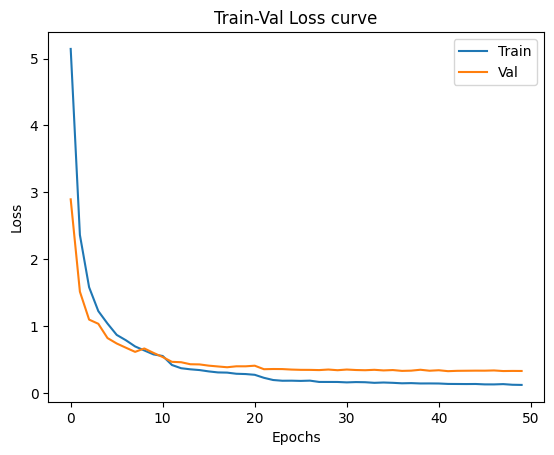

In [31]:
vizualize_lr_curve(history)

The graph shows the model has almost overcome the overfitting, (but yeah still it contains some)

In [32]:
model.save("/content/drive/MyDrive/data/intentClassif/intent_clf.keras")

In [33]:
import pickle

# Save the tokenizer to a file using pickle
with open('/content/drive/MyDrive/data/intentClassif/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# # Load the tokenizer using pickle
# with open('/content/drive/MyDrive/data/intentClassif/tokenizer.pkl', 'rb') as tokenizer_file:
#     loaded_tokenizer = pickle.load(tokenizer_file)

# Testing

In [34]:
def pipe(txt):
  txt = clean_text(txt)
  seq = tokenizer.texts_to_sequences([txt])
  seq = pad_sequences(seq, maxlen = max_len, padding = 'post', value=0)
  # model = tf.keras.models.load_model("intent_clf.keras")
  ypred = model.predict(seq, verbose='0')
  intent = np.argmax(ypred[0])
  return intent_dict[intent]



In [35]:
tdf['intent_txt'] = tdf['intent'].apply(lambda x:intent_dict[x])

In [36]:
intent_dict

{0: 'restaurant_reviews',
 1: 'nutrition_info',
 2: 'account_blocked',
 3: 'oil_change_how',
 4: 'time',
 5: 'weather',
 6: 'redeem_rewards',
 7: 'interest_rate',
 8: 'gas_type',
 9: 'accept_reservations',
 10: 'smart_home',
 11: 'user_name',
 12: 'report_lost_card',
 13: 'repeat',
 14: 'whisper_mode',
 15: 'what_are_your_hobbies',
 16: 'order',
 17: 'jump_start',
 18: 'schedule_meeting',
 19: 'meeting_schedule',
 20: 'freeze_account',
 21: 'what_song',
 22: 'meaning_of_life',
 23: 'restaurant_reservation',
 24: 'traffic',
 25: 'make_call',
 26: 'text',
 27: 'bill_balance',
 28: 'improve_credit_score',
 29: 'change_language',
 30: 'no',
 31: 'measurement_conversion',
 32: 'timer',
 33: 'flip_coin',
 34: 'do_you_have_pets',
 35: 'balance',
 36: 'tell_joke',
 37: 'last_maintenance',
 38: 'exchange_rate',
 39: 'uber',
 40: 'car_rental',
 41: 'credit_limit',
 42: 'oos',
 43: 'shopping_list',
 44: 'expiration_date',
 45: 'routing',
 46: 'meal_suggestion',
 47: 'tire_change',
 48: 'todo_list

In [37]:
tdf[tdf['intent'] == 100].sample(2)

,text,intent,intent_txt
570,i need help with my 401k rollover because i ju...,100,rollover_401k
565,can the 401k i have be rolled over,100,rollover_401k


In [38]:
tdf[tdf['intent'] == 12].sample(2)

,text,intent,intent_txt
1419,my card is lost and i need to know how to repo...,12,report_lost_card
1418,i need the information on how to report a lost...,12,report_lost_card


In [39]:
while(True):
  q = str(input("Enter prompt : "))
  if q == 'ex':
    break
  else:
    print("intent : ", pipe(q))

Enter prompt : Please play a song
intent :  play_music
Enter prompt : which music is good for health
intent :  play_music
Enter prompt : can you suggest me place to visit
intent :  travel_suggestion
Enter prompt : i have lost my ID card
intent :  report_lost_card
Enter prompt : pay the bill
intent :  pay_bill
Enter prompt : can you please abort the flight reservation
intent :  cancel_reservation
Enter prompt : where can i visit on my next weekend
intent :  travel_suggestion
Enter prompt : how to bake a cake
intent :  recipe
Enter prompt : can you suggest what food i can eat today
intent :  meal_suggestion
Enter prompt : Thanks
intent :  thank_you
Enter prompt : Hi there
intent :  greeting
Enter prompt : Hi can you help you on something ?
intent :  greeting
Enter prompt : hi i got an emergency
intent :  greeting
Enter prompt : i got an emergency
intent :  thank_you
Enter prompt : i want to loose some calories
intent :  calories
Enter prompt : please translate this letter in German
inten